For a recent talk in my department I talked a little bit about agent based modeling and in the process I came across the simple but quite interesting SIR model in epidemiology. The inspiration for this notebook was Simon Dobson's post on [Epidemic spreading processes](http://www.simondobson.org/complex-networks-complex-processes/epidemic-spreading.html), which will provide a much more detailed scientific background and take you through some of the code step by step. However as a brief introduction

I've made some minor tweaks to the model by adding vaccinated and dead states. I've also unified the function based approach into a single Parameterized class, which takes care of initializing, running and visualizing the network.

In this notebook I'll primarily look at how we can quickly create complex visualization about this model using HoloViews. In the process I'll look at some predictions this model can make about herd immunity but won't be giving it any rigorous scientific treatment.

## The Code

Here's the code for the model relying only on numpy, networkx, holoviews and matplotlib in the background.

In [1]:
import collections
import itertools
import math

import numpy as np
np.seterr(divide='ignore')
import numpy.random as rnd
import networkx as nx

import param
import holoviews as hv


class SRI_Model(param.Parameterized):
    """
    Implementation of the SRI epidemiology model
    using NetworkX and HoloViews for visualization.
    This code has been adapted from Simon Dobson's
    code here:
    
    http://www.simondobson.org/complex-networks-complex-processes/epidemic-spreading.html
    
    In addition to his basic parameters I've added
    additional states to the model, a node may be
    in one of the following states:
    
      * Susceptible: Can catch the disease from a connected node.
      * Vaccinated: Immune to infection.
      * Infected: Has the disease and may pass it on to any connected node.
      * Recovered: Immune to infection.
      * Dead: Edges are removed from graph.
    """

    network = param.ClassSelector(class_=nx.Graph, default=None, doc="""
        A custom NetworkX graph, instead of the default Erdos-Renyi graph.""")
    
    visualize = param.Boolean(default=True, doc="""
        Whether to compute layout of network for visualization.""")
    
    N = param.Integer(default=1000, doc="""
        Number of nodes to simulate.""")
    
    mean_connections = param.Number(default=10, doc="""
        Mean number of connections to make to other nodes.""")
    
    pSick = param.Number(default=0.01, doc="""
        Probability of a node to be initialized in sick state.""", bounds=(0, 1))

    pVaccinated = param.Number(default=0.1, bounds=(0, 1), doc="""
        Probability of a node to be initialized in vaccinated state.""")
    
    pInfect = param.Number(default=0.3, doc="""
        Probability of infection on each time step.""", bounds=(0, 1))
    
    pRecover = param.Number(default=0.05, doc="""
        Probability of recovering if infected on each timestep.""", bounds=(0, 1))
    
    pDeath = param.Number(default=0.1, doc="""
        Probability of death if infected on each timestep.""", bounds=(0, 1))
    
    
    SPREADING_SUSCEPTIBLE = 'S'
    SPREADING_VACCINATED = 'V'
    SPREADING_INFECTED = 'I'
    SPREADING_RECOVERED = 'R'
    DEAD = 'D'

    def __init__(self, **params):
        super(SRI_Model, self).__init__(**params)
        if not self.network:
            self.g = nx.erdos_renyi_graph(self.N, float(self.mean_connections)/self.N)
        else:
            self.g = self.network
        self.vaccinated, self.infected = self.spreading_init()
        self.model = self.spreading_make_sir_model()
        self.color_mapping = [self.SPREADING_SUSCEPTIBLE,
                              self.SPREADING_VACCINATED,
                              self.SPREADING_INFECTED,
                              self.SPREADING_RECOVERED, self.DEAD]
        if self.visualize:
            k = 2/(math.sqrt(self.g.order()))
            self.pos = hv.Graph.from_networkx(self.g, nx.spring_layout, iterations=50, k=k)

    def spreading_init(self):
        """Initialise the network with vaccinated, susceptible and infected states."""
        vaccinated, infected = 0, []
        for i in self.g.node.keys():
            self.g.node[i]['transmissions'] = 0
            if(rnd.random() <= self.pVaccinated): 
                self.g.node[i]['state'] = self.SPREADING_VACCINATED
                vaccinated += 1
            elif(rnd.random() <= self.pSick):
                self.g.node[i]['state'] = self.SPREADING_INFECTED
                infected.append(i)
            else:
                self.g.node[i]['state'] = self.SPREADING_SUSCEPTIBLE
        return vaccinated, infected

    def spreading_make_sir_model(self):
        """Return an SIR model function for given infection and recovery probabilities."""
        # model (local rule) function
        def model( g, i ):
            if g.node[i]['state'] == self.SPREADING_INFECTED:
                # infect susceptible neighbours with probability pInfect
                for m in g.neighbors(i):
                    if g.node[m]['state'] == self.SPREADING_SUSCEPTIBLE:
                        if rnd.random() <= self.pInfect:
                            g.node[m]['state'] = self.SPREADING_INFECTED
                            self.infected.append(m)
                            g.node[i]['transmissions'] += 1

                # recover with probability pRecover
                if rnd.random() <= self.pRecover:
                    g.node[i]['state'] = self.SPREADING_RECOVERED
                elif rnd.random() <= self.pDeath:
                    edges = [edge for edge in self.g.edges() if i in edge] 
                    g.node[i]['state'] = self.DEAD
                    g.remove_edges_from(edges)

        return model

    def step(self):
        """Run a single step of the model over the graph."""
        for i in self.g.node.keys():
            self.model(self.g, i)

    def run(self, steps):
        """
        Run the network for the specified number of time steps
        """
        for i in range(steps):
            self.step()

    def stats(self):
        """
        Return an ItemTable with statistics on the network data.
        """
        state_labels = hv.OrderedDict([('S', 'Susceptible'), ('V', 'Vaccinated'), ('I', 'Infected'),
                                       ('R', 'Recovered'), ('D', 'Dead')])
        counts = collections.Counter()
        transmissions = []
        for n in self.g.nodes():
            state = state_labels[self.g.node[n]['state']]
            counts[state] += 1
            if n in self.infected:
                transmissions.append(self.g.node[n]['transmissions'])
        data = hv.OrderedDict([(l, counts[l])
                               for l in state_labels.values()])
        
        infected = len(set(self.infected))
        unvaccinated = float(self.N-self.vaccinated)
        
        data['$R_0$'] = np.mean(transmissions) if transmissions else 0
        data['Death rate DR'] = np.divide(float(data['Dead']),self.N)
        data['Infection rate IR'] = np.divide(float(infected), self.N)
        if unvaccinated:
            unvaccinated_dr = data['Dead']/unvaccinated
            unvaccinated_ir = infected/unvaccinated
        else:
            unvaccinated_dr = 0
            unvaccinated_ir = 0
        data['Unvaccinated DR'] = unvaccinated_dr
        data['Unvaccinated IR'] = unvaccinated_ir
        return hv.ItemTable(data)

    def animate(self, steps):
        """
        Run the network for the specified number of steps accumulating animations
        of the network nodes and edges changing states and curves tracking the
        spread of the disease.
        """
        if not self.visualize:
            raise Exception("Enable visualize option to get compute network visulizations.")

        # Declare HoloMap for network animation and counts array
        network_hmap = hv.HoloMap(kdims='Time')
        sird = np.zeros((steps, 5))
        
        # Declare labels
        state_labels = ['Susceptible', 'Vaccinated', 'Infected', 'Recovered', 'Dead']

        # Text annotation
        nlabel = hv.Text(0.9, 0.05, 'N=%d' % self.N)

        for i in range(steps):
            # Get path, point, states and count data
            states = [self.g.node[n]['state'] for n in self.g.nodes()]
            state_ints = [self.color_mapping.index(v) for v in states]
            state_array = np.array(state_ints, ndmin=2).T
            (sird[i, :], _) = np.histogram(state_array, bins=list(range(6)))

            # Create network path and node Elements
            nodes = self.pos.nodes.clone(datatype=['dictionary'])
            nodes = nodes.add_dimension('State', 0, states, True)
            graph = self.pos.clone((self.pos.data.copy(), nodes))
            # Create overlay and accumulate in network HoloMap
            network_hmap[i] = (graph * nlabel).relabel(group='Network', label='SRI')
            self.step()

        # Create Overlay of Curves
        #extents = (-1, -1, steps, np.max(sird)+2)
        curves = hv.NdOverlay({label: hv.Curve(zip(range(steps), sird[:, i]),
                                               'Time', 'Count')
                              for i, label in enumerate(state_labels)},
                              kdims=[hv.Dimension('State', values=state_labels)])
        
        # Animate VLine on top of Curves
        distribution = hv.HoloMap({i: (curves * hv.VLine(i)).relabel(group='Counts', label='SRI')
                                   for i in range(steps)}, kdims='Time')
        
        return network_hmap + distribution

## The style

HoloViews allows use to define various style options in advance on the Store.options object.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
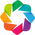

In [2]:
hv.extension('bokeh', 'matplotlib')

# Set colors and style options for the Element types
from holoviews import Store, Options
opts = Store.options()

colormap = {k: v for k, v in zip('SVIRD', hv.Cycle().values)}

opts.Graph     = Options('plot', color_index='State')
opts.Graph     = Options('style', cmap=colormap, node_size=6, edge_line_width=1)
opts.Histogram = Options('plot', show_grid=False)
opts.Overlay   = Options('plot', show_frame=False)
opts.HeatMap   = Options('plot', xrotation=90)
opts.ItemTable = Options('plot', width=900, height=50)

opts.Overlay.Network = Options('plot', xaxis=None, yaxis=None)
opts.Overlay.Counts  = Options('plot', show_grid=True)

opts.VLine     = {'style': Options(color='black', line_width=1),
                  'plot':  Options(show_grid=True)}

# Herd Immunity

### Experiment 1: Evaluating the effects of a highly infectious and deadly disease in a small population with varying levels of vaccination

Having defined the model and defined the model we can run some real experiments. In particular we can investigate the effect of vaccination on our model.

We'll initialize our model with only 50 inviduals, who will on average make 10 connections to other individuals. Then we will infect a small population ($p=0.1$) so we can track how the disease spreads through the population. To really drive the point home we'll use a very infectious and deadly disease.

In [3]:
experiment1_params = dict(pInfect=0.08, pRecover=0.08, pSick=0.15,
                          N=50, mean_connections=10, pDeath=0.1)

## Low vaccination population (10%)

Here we'll investigate the spread of the disease in population with a 10% vaccination rate:

In [4]:
sri_model = SRI_Model(pVaccinated=0.1, **experiment1_params)
sri_model.animate(21).redim.range(x=(-1.2, 1.2), y=(-1.2, 1.2))

:Layout
   .Network.SRI :HoloMap   [Time]
      :Overlay
         .Graph.I :Graph   [start,end]
         .Text.I  :Text   [x,y]
   .Counts.SRI  :HoloMap   [Time]
      :Overlay
         .NdOverlay.I :NdOverlay   [State]
            :Curve   [Time]   (Count)
         .VLine.I     :VLine   [x,y]

In figure **A** we can observe how the disease quickly spreads across almost the entire unvaccinated population. Additionally we can track the number of individuals in a particular state in **B**. As the disease spreads unimpeded the most individuals either die or recover and therefore gain immunity. Individuals that die are obviously no longer part of the network so their connections to other individuals get deleted, this way we can see the network thin out as the disease wreaks havok among the population.

Next we can view a breakdown of the final state of the simulation including infection and death rates:

In [5]:
sri_model.stats().opts(hv.opts.ItemTable(width=900, height=50))

:ItemTable   (Susceptible,Vaccinated,Infected,Recovered,Dead,$R_0$,Death rate DR,Infection rate IR,Unvaccinated DR,Unvaccinated IR)

As you can see both the infection and death rates are very high in this population. The disease reached a large percentage all individuals causing death in a large fraction of them. Among the unvaccinated population they are of course even higher with almost >90% infected and >40% dead. The disease spread through our network completely unimpeded. Now let's see what happens if a large fraction of the population is vaccinated.

## High vaccination population (65%)

If we increase the initial probability of being vaccinated to $p=0.65$ we'll be able to observe how this affects the spread of the disease through the network: 

In [6]:
sri_model = SRI_Model(pVaccinated=0.65, **experiment1_params)
sri_model.animate(21)

:Layout
   .Network.SRI :HoloMap   [Time]
      :Overlay
         .Graph.I :Graph   [start,end]
         .Text.I  :Text   [x,y]
   .Counts.SRI  :HoloMap   [Time]
      :Overlay
         .NdOverlay.I :NdOverlay   [State]
            :Curve   [Time]   (Count)
         .VLine.I     :VLine   [x,y]

Even though we can still see the disease spreading among non-vaccinated individuals we can also observe how the vaccinated individuals stop the spread. If an infected individual is connected with a majority of vaccinated indivuals the probability of the disease spreading is strongly impeded. Unlike in low vaccinated population the disease stops its spread not because too many individuals have died off, rather it quickly runs out of steam, such that a majority of the initial, susceptible but healthy population remains completely unaffected. 

This is what's known as herd immunity and its very important. This is because a small percentage of any population cannot be vaccinated, usually because they are immuno-compromised. However when a larger percentage of people decide that they do not want to get vaccinated (for various and invariably stupid reasons), they place the rest of the population in danger, particularly those that cannot get vaccinated for health reasons.

Let's look what higher vaccination rates did to our experimental population:

In [7]:
sri_model.stats()

:ItemTable   (Susceptible,Vaccinated,Infected,Recovered,Dead,$R_0$,Death rate DR,Infection rate IR,Unvaccinated DR,Unvaccinated IR)

The precipetous drop in the whole populations infection rate and death rate are obviously easily explained by the fact that a smaller fraction of the population was susceptible to the disease in the first place, however as herd immunity would predict, a smaller fraction of the unvaccinated population contracted and died of the disease as well. I hope this toy example once again emphasizes how important vaccination and herd immunity is.

## Large networks

Before we have a more systematic look at herd immunity we'll increase the population size to 1000 individuals and have a look at what our virulent disease does to this population, if nothing else it'll produce a pretty plot.

In [8]:
hv.output(holomap='scrubber', size=150)
sri_model_lv = SRI_Model(pVaccinated=0.1, **dict(experiment1_params, N=1000))
sri_layout = sri_model_lv.animate(31)
sri_layout.Network.SRI[::2]

:HoloMap   [Time]
   :Overlay
      .Graph.I :Graph   [start,end]
      .Text.I  :Text   [x,y]

In [9]:
sri_model_hv = SRI_Model(pVaccinated=0.65, visualize=False, **dict(experiment1_params, N=1000))
sri_model_hv.run(100)
(sri_model_lv.stats().relabel('Low Vaccination Population') +
 sri_model_hv.stats().relabel('High Vaccination Population')).cols(1)

:Layout
   .ItemTable.Low_Vaccination_Population  :ItemTable   (Susceptible,Vaccinated,Infected,Recovered,Dead,$R_0$,Death rate DR,Infection rate IR,Unvaccinated DR,Unvaccinated IR)
   .ItemTable.High_Vaccination_Population :ItemTable   (Susceptible,Vaccinated,Infected,Recovered,Dead,$R_0$,Death rate DR,Infection rate IR,Unvaccinated DR,Unvaccinated IR)

As we can see the effect we observed in our smaller simulations from above still hold. Unvaccinated individuals are much safer in the high vaccination population than they are in the low vaccine population.

### Experiment 2: Systematically exploring the effect of vaccination rates and connectivity on infection and death rates in a large population

Now let's conduct a more systematic experiment by varying the vaccination rate and number of connections between individuals. In Experiment 1 we saw that vaccination rates could drastically reduce infection and death rates even among the unvaccinated population. Here we'll use a much less deadly disease as we're primarily interested in is how the disease spreads through populations with more and less connections and different vaccination rates. We'll also use a larger population (N=1000) to get a more representative sample. 

In [10]:
experiment2_params = dict(N=1000, pInfect=0.05, pRecover=0.05,
                          pSick=0.05, pDeath=0.001, visualize=False)

Now we explore the parameter space, we'll run the model for vaccination rates from 0% to 100% in 5% increments and for increasing numbers of connections. To speed the whole thing up we've disabled computing the network layout with the ``visualize`` parameter and will only be collecting the final simulation statistics. Finally we can simply deconstruct our data into a pandas data frame.

In [11]:
exp2_dims = ['Connections', 'pVaccinated']
hmap = hv.HoloMap(kdims=exp2_dims)
vacc_rates = np.linspace(0, 1, 21)
mean_conns = [2**i for i in range(7)]
for v, c in itertools.product(vacc_rates, mean_conns):
    sri_model = SRI_Model(mean_connections=c, pVaccinated=v, **experiment2_params)
    sri_model.run(100)
    hmap[c, v] = sri_model.stats()
df = hmap.dframe()

Before we start visualizing this data let's have a look at it:

In [12]:
df[::20]

,pVaccinated,Connections,Susceptible,Vaccinated,Infected,Recovered,Dead,$R_0$,Death rate DR,Infection rate IR,Unvaccinated DR,Unvaccinated IR
0,0.00,1,895,0,3,101,1,0.466667,0.001,0.105,0.001000,0.105000
0,1.00,1,0,1000,0,0,0,0.000000,0.000,0.000,0.000000,0.000000
0,0.95,2,55,942,0,3,0,0.000000,0.000,0.003,0.000000,0.051724
0,0.90,4,96,900,0,4,0,0.000000,0.000,0.004,0.000000,0.040000
0,0.85,8,141,845,0,13,1,0.428571,0.001,0.014,0.006452,0.090323
0,0.80,16,40,808,5,144,3,0.934211,0.003,0.152,0.015625,0.791667
0,0.75,32,4,751,3,238,4,0.910204,0.004,0.245,0.016064,0.983936
0,0.70,64,0,704,3,291,2,0.945946,0.002,0.296,0.006757,1.000000


### Regressions between vaccination, infection and death rates

Using the HoloViews pandas and seaborn extensions we can now perform regressions on the vaccination rates against infection and death rates. However since we also varied the mean number of connections between individuals in the network we want to consider these variables independently. By assigning the number of connections to a HoloMap we can view each plot independently with a widget.

Let's define the quantities we want to visualize and switch to matplotlib for these last few plots:

In [13]:
quantities = ['Unvaccinated IR', 'Infection rate IR', 'Death rate DR', '$R_0$']
state_labels = ['Susceptible', 'Vaccinated', 'Infected', 'Recovered', 'Dead']

hv.output(backend='matplotlib')

:Layout
   .R_0.I            :TriSurface   [pVaccinated,Connections]   ($R_0$)
   .Infection_Rate.I :TriSurface   [pVaccinated,Connections]   (Infection rate IR)
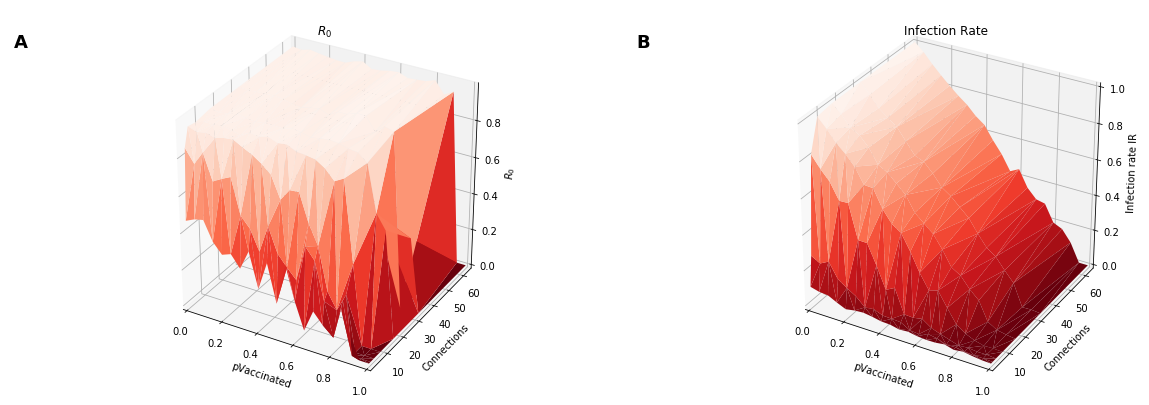

In [14]:
hv.opts.defaults(
    hv.opts.Layout(fig_size=200),
    hv.opts.TriSurface(cmap='Reds_r', linewidth=0.1)
)
ds = hv.Dataset(df)
(ds.to.trisurface(['pVaccinated', 'Connections'], '$R_0$', [], group='$R_0$') +
 ds.to.trisurface(['pVaccinated', 'Connections'], 'Infection rate IR', [], group='Infection Rate'))

By varying the number of connections we can observe second order effects that would usually be invisible to us. After playing around with it for a little we can draw the following conclusions:

* Greater number of connections in the network lead to drastically higher infection and death rates.
* Infection rates scale linearly with death rates for very low and very high number of connections.
* For intermediate levels of network connectivity the relationship between vaccination and infection rates more closely resembles exponential decay, i.e. achieving a basic level of vaccination in a population has a greater payoff than boosting vaccination rates in populations where they are already high.
* The more highly connected a population the higher the vaccination rates have to be to effectively protect the population.

These results emphasize how important it is to maintain high vaccination rates in the highly connected societies we live in today. Even more importantly they show how important it is to continue vaccination programs in developing countries where they'll have the greatest impact.

We can also present the data in a different way examining all the data at once in a HeatMap.

:Layout
   .Unvaccinated_IR.I   :AdjointLayout
      :HeatMap   [pVaccinated,Connections]   (Unvaccinated IR)
      :Histogram   [Unvaccinated IR]   (Unvaccinated IR_frequency)
   .Infection_rate_IR.I :AdjointLayout
      :HeatMap   [pVaccinated,Connections]   (Infection rate IR)
      :Histogram   [Infection rate IR]   (Infection rate IR_frequency)
   .Death_rate_DR.I     :AdjointLayout
      :HeatMap   [pVaccinated,Connections]   (Death rate DR)
      :Histogram   [Death rate DR]   (Death rate DR_frequency)
   .R_0.I               :AdjointLayout
      :HeatMap   [pVaccinated,Connections]   ($R_0$)
      :Histogram   [$R_0$]   ($R_0$_frequency)
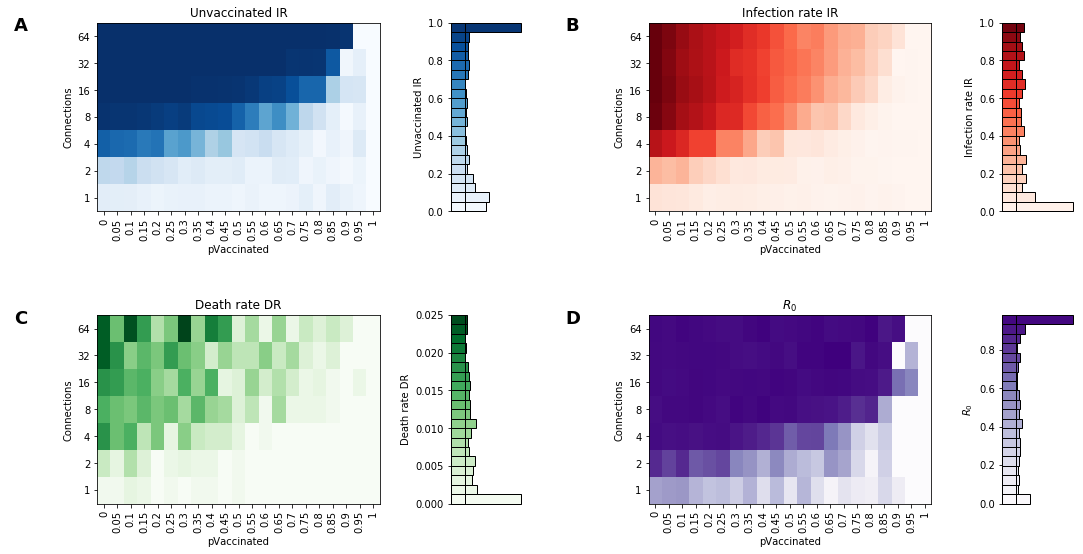

In [15]:
hv.opts.defaults(
    hv.opts.HeatMap(show_values=False, aspect=1.5, xrotation=90),
    hv.opts.Histogram(axiswise=True),
    hv.opts.Layout(fig_size=150),
)
group_colors = zip(quantities, ['Blues', 'Reds', 'Greens', 'Purples'])
hv.Layout([hv.Table(df).to.heatmap(['pVaccinated', 'Connections'],
                                   q, [], group=q).opts(style=dict(cmap=c)).hist()
           for q, c in group_colors]).cols(2)

This view highlights the gradient along which vaccination is highly effective and then becoming less effective as the saturation of the colors increases.

### Summary

Remember "It's only a model", and a fairly simple one at that, but it provides some very clear predictions, which we've also observed in the real world. Getting the most out of models like this or even far more complex simulations requires tools that will allow us to make sense of interactions between many variables. I hope this notebook has gone some way towards persuading you that HoloViews is that tool, if so have a look at the [HoloViews website](https://holoviews.org) for more information.

#### Your turn

The ``SRI_Model`` class provided above is deliberately very customizable. If you want to play with the model further try varying some other parameters and explore the effects on the model or supply your own network via the ``network`` parameter. There are a variety of tools to extract NetworkX Graph structures, so you could put together a model of your own social network. Hope you enjoyed it and have fun!